# Simulate Thompson Subsampling

Thompson sampling approach requires updating posteriors for each iteration, however, in each iteration we only know one new label and that may be supply much information for updating. So instead of updating all posteriors we uniformly random sample some entities and relations to update. 

We experiments on how subsampling affects the ROC_AUC_SCORE, cumulative gain as well as running time.

Evaluation metrics:

(1)ROC_AUC_SCORE: calculated between true labels and predictions for each iterations  
(2)Cumulative gain: for each iteration, if the maximum prediction corresponding with the valid labels gain 1, otherwise 0. Show cumulative gain for all iterations.
(3)running time: average running time for each iteration

We chose repeated labelling and Thompson Sampling for 5,000 iterations, and used [NATIONS](https://github.com/dongwookim-ml/kg-data) dataset as an example, there are totally 2,024 valid triples. 

Experiments: 

subn_ent = [2,5,10,n_entities]  
subn_rel = [2,5,10,n_relations]


In [1]:
# direct to parent folder
import sys
sys.path.append("../acton")

from acton.database import GraphReader, GraphDatabase
from acton.predictors import TensorPredictor
from acton.recommenders import ThompsonSamplingRecommender
from acton.labellers import GraphDatabaseLabeller
import acton.acton
import tempfile
import astropy.io.ascii as io_ascii
import os.path
import numpy
import logging
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict

/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
logging.basicConfig(level = logging.DEBUG)

_path = 'kg-data/nation/triples.txt'
output_path = 'acton.proto'
outfile_path = "ts_subsampling_exper2/"
n_dim = 10
TS= 0.0
RANDOM = 1.0

In [ ]:
with GraphReader(_path, n_dim) as reader:
    n_relations = reader.n_relations
    n_entities = reader.n_entities
    totoal_size = n_relations * n_entities * n_entities
    ids = numpy.arange(totoal_size)
    
    N_EPOCHS = 5000
    repeated_labelling = True

    results = defaultdict(list)
    
    subn_ent = [2,3,5,10,n_entities,n_entities]
    subn_rel = [2,3,5,10,20,n_relations]
    
    # rtrs: repeated train ROC-AUC-SCORE
    # rtes: repeated test ROC-AUC-SCORE
    # rg: repeated cumulative gain
    
    for i in range(len(subn_ent)):
        subn_entities = subn_ent[i]
        subn_relations = subn_rel[i]
    
        label = '_e' + str(subn_entities) + '_r' + str(subn_relations)
        logging.debug(label)
        
        results['TS_rtrs' + label], results['TS_rtes' + label],\
        results['TS_rg' + label], results['time' + label] =  \
            acton.acton.simulate_active_learning(
                ids, reader, {}, output_path,
                n_epochs=N_EPOCHS,
                recommender='ThompsonSamplingRecommender',
                predictor='TensorPredictor',
                labeller='GraphDatabaseLabeller',
                diversity=TS,
                repeated_labelling=repeated_labelling,
                subn_entities = int(subn_entities),
                subn_relations = int(subn_relations)
        )
    
    with open(outfile_path + 'outfile', 'wb') as fp:
        pickle.dump(results,fp)    

In [37]:
with open (outfile_path + 'outfile', 'rb') as fp:
    results = pickle.load(fp)

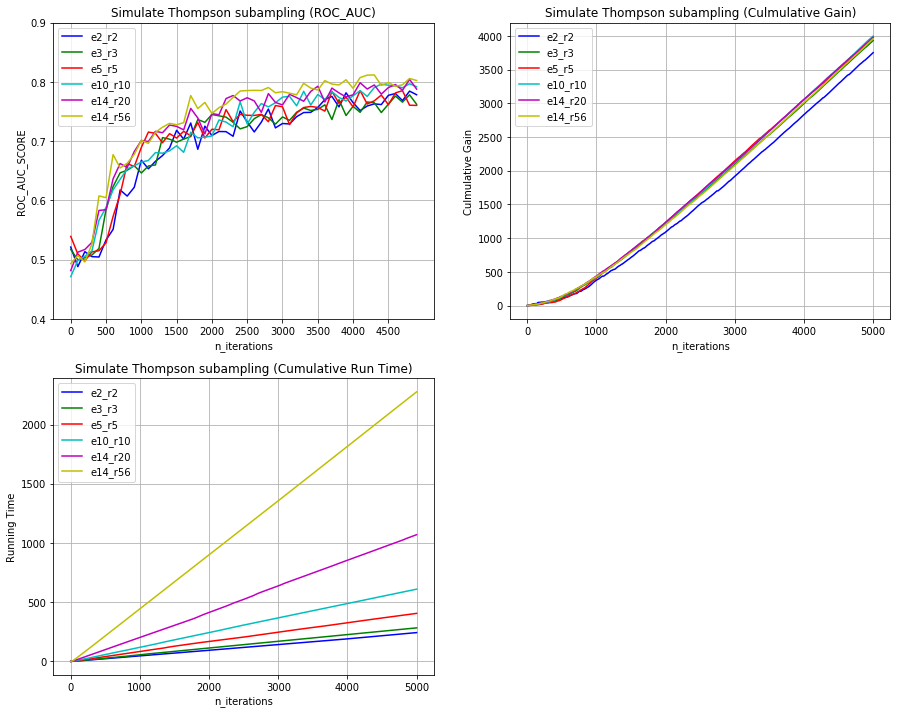

In [45]:
# with open ('outfile_sub50', 'rb') as fp:
#    results = pickle.load(fp)

plt.figure(figsize= (15,12))

subn_ent = [2,3,5,10,n_entities,n_entities]
subn_rel = [2,3,5,10,20,n_relations]
color = ['b', 'g', 'r', 'c', 'm', 'y']
    
# rtrs: repeated train ROC-AUC-SCORE
# rtes: repeated test ROC-AUC-SCORE
# rg: repeated cumulative gain

plt.subplot(221)
for i in range(len(subn_ent)):
    subn_entities = subn_ent[i]
    subn_relations = subn_rel[i]

    label = '_e' + str(subn_entities) + '_r' + str(subn_relations)
    plt.plot(results['TS_rtrs' + label][::100], label = label[1:], color = color[i])

plt.ylabel('ROC_AUC_SCORE')
plt.xlabel('n_iterations')
plt.xticks(numpy.arange(50, step = 5), numpy.arange(5000)[::500])
plt.ylim(0.4,0.9)
plt.title('Simulate Thompson subampling (ROC_AUC)')
plt.grid(True)
plt.legend()

plt.subplot(222)
for i in range(len(subn_ent)):
    subn_entities = subn_ent[i]
    subn_relations = subn_rel[i]

    label = '_e' + str(subn_entities) + '_r' + str(subn_relations)
    plt.plot(numpy.cumsum(results['TS_rg' + label]), label = label[1:], color = color[i])

plt.ylabel('Culmulative Gain')
plt.xlabel('n_iterations')
#plt.ylim(0,1300)
plt.title('Simulate Thompson subampling (Culmulative Gain)')
plt.grid(True)
plt.legend()

plt.subplot(223)
for i in range(len(subn_ent)):
    subn_entities = subn_ent[i]
    subn_relations = subn_rel[i]

    label = '_e' + str(subn_entities) + '_r' + str(subn_relations)
    plt.plot(numpy.cumsum(results['time' + label]), label = label[1:], color = color[i])

plt.ylabel('Running Time')
plt.xlabel('n_iterations')
#plt.ylim(0,1300)
plt.title('Simulate Thompson subampling (Cumulative Run Time)')
plt.grid(True)
plt.legend()


### plot gain vs running time

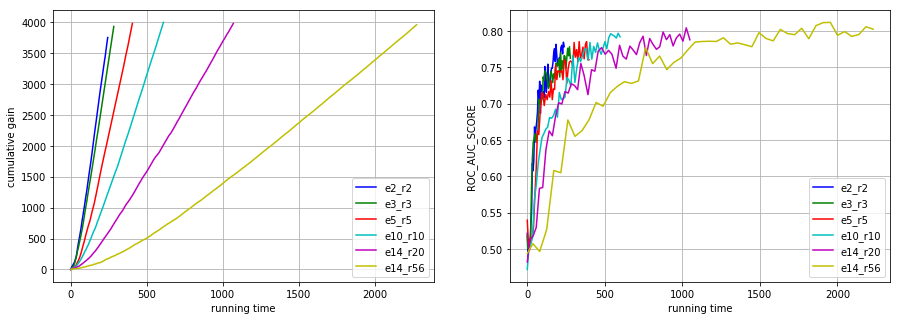

In [47]:
plt.figure(figsize= (15,5))

subn_ent = [2,3,5,10,n_entities,n_entities]
subn_rel = [2,3,5,10,20,n_relations]
color = ['b', 'g', 'r', 'c', 'm', 'y']
    
# rtrs: repeated train ROC-AUC-SCORE
# rtes: repeated test ROC-AUC-SCORE
# rg: repeated cumulative gain

plt.subplot(121)
for i in range(len(subn_ent)):
    subn_entities = subn_ent[i]
    subn_relations = subn_rel[i]

    label = '_e' + str(subn_entities) + '_r' + str(subn_relations)
    plt.plot(numpy.cumsum(results['time'+label]), 
         numpy.cumsum(results['TS_rg'+label]), label=label[1:], color = color[i])
    
plt.xlabel("running time")
plt.ylabel("cumulative gain")
plt.legend()
plt.grid(True)

plt.subplot(122)
for i in range(len(subn_ent)):
    subn_entities = subn_ent[i]
    subn_relations = subn_rel[i]

    label = '_e' + str(subn_entities) + '_r' + str(subn_relations)
    plt.plot(numpy.cumsum(results['time'+label])[::100], 
         results['TS_rtrs'+label][::100], label=label[1:], color = color[i])   
plt.xlabel("running time")
plt.ylabel("ROC_AUC_SCORE")
plt.legend()
plt.grid(True)
